In [1]:
%pip install rouge_score==0.1.2

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5bd68e5643a79d4b8aff41418e80279533eaabd3f8787506569fc42fbe4628eb
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install -U accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 22.6 MB/s eta 0:00:00


In [4]:
mkdir cache

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_path = "/content/drive/MyDrive/4th_year/Research_project/Dataset/cnn_dailymail/train.csv"
validation_path = "/content/drive/MyDrive/4th_year/Research_project/Dataset/cnn_dailymail/validation.csv"
test_path = "/content/drive/MyDrive/4th_year/Research_project/Dataset/cnn_dailymail/test.csv"

In [7]:
import torch
import pandas as pd

test_df = pd.read_csv(test_path)

In [8]:
import numpy as np

sample_size = 1000

# Select the first 1000 rows
sample = test_df.head(sample_size)

# Reset the index to be from 0 to 999
sample = sample.reset_index(drop=True)

sample

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."
...,...,...,...
995,b8504230c7647905078698183f2dda0ce11b8182,Women travelling on the London Underground are...,Transport for London used actors in the uncomf...
996,8f87f30d3cd9eb25ca0759e0dad11befce3f898c,Millions of devout Christians around the world...,WARNING: GRAPHIC CONTENT .\nThe week-long fest...
997,788350d50e6858fddaf1095b9ac026d82fae79c1,Floyd Mayweather and Manny Pacquiao may only b...,Floyd Mayweather and Manny Pacquiao fight in L...
998,76faa51c29068226495bdaf2d928f176e7d3b8f5,Nigel Farage suffered a fresh blow today after...,ComRes survey for ITV shows Ukip falling behin...


In [9]:
example_article = sample["article"][0]
example_summary = sample["highlights"][0]
print(f"Article:\n{example_article}\n")
print(f"Summary:\n{example_summary}")

Article:
Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee. 'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fighting f

**Summarization**

In [10]:
import pandas as pd
import torch
import gc
from transformers import AutoTokenizer, T5ForConditionalGeneration

In [11]:
def batch_generator(data: list, batch_size: int):
    """
    Creates batches of size `batch_size` from a list.
    """
    s = 0
    e = s + batch_size
    while s < len(data):
        yield data[s:e]
        s = e
        e = min(s + batch_size, len(data))

prompt_template = "You are a news editor. Summarize the following article concisely: {article}"

def summarize_with_t5(
    model_checkpoint: str, articles: list, batch_size: int = 8,  prompt_template: str = prompt_template
) -> list:
    """
    Compute summaries using a T5 model.
    This is similar to a `pipeline` for a T5 model but does tokenization manually.

    :param model_checkpoint: Name for a model checkpoint in Hugging Face, such as "t5-small" or "t5-base"
    :param articles: List of strings, where each string represents one article.
    :param prompt_template: Template for the summarization prompt.
    :return: List of strings, where each string represents one article's generated summary
    """
    if torch.cuda.is_available():
        device = "cuda:0"
    else:
        device = "cpu"

    model = T5ForConditionalGeneration.from_pretrained(
        model_checkpoint, cache_dir="../working/cache"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(
        model_checkpoint, model_max_length=1024, cache_dir="../working/cache"
    )

    def perform_inference(batch: list) -> list:
        inputs = tokenizer(
            batch, max_length=1024, return_tensors="pt", padding=True, truncation=True
        )

        summary_ids = model.generate(
            inputs.input_ids.to(device),
            attention_mask=inputs.attention_mask.to(device),
            num_beams=2,
            min_length=0,
            max_length=40,
        )
        return tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

    res = []

    summary_articles = list(map(lambda article: prompt_template.format(article=article), articles))
    for batch in batch_generator(summary_articles, batch_size=batch_size):
        res += perform_inference(batch)

        torch.cuda.empty_cache()
        gc.collect()

    # clean up
    del tokenizer
    del model
    torch.cuda.empty_cache()
    gc.collect()
    return res

**T5-Small** is the checkpoint with **60 million parameters**.

In [12]:
t5_small_summaries = summarize_with_t5("t5-small", sample["article"], prompt_template="You are a news editor. Summarize the following article concisely: {article}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [13]:
reference_summaries = sample["highlights"]

In [14]:
display(
    pd.DataFrame.from_dict(
        {
            "generated": t5_small_summaries,
            "reference": reference_summaries,
        }
    )
)

,generated,reference
0,",,,,,:? is putting our health and safety in da...",Experts question if packed out planes are put...
1,"Rahul Kumar, 17, climbed into a lions' enclosu...",Drunk teenage boy climbed into lion enclosure ...
2,Dougie Freedman is set to sign a new two-year ...,Nottingham Forest are close to extending Dougi...
3,Neto is wanted by a number of top European clu...,Fiorentina goalkeeper Neto has been linked wit...
4,"Jenner, 65, will speak out in a 'far-ranging' ...","Tell-all interview with the reality TV star, 6..."
...,...,...
995,a video shows a female commuter groping her re...,Transport for London used actors in the uncomf...
996,thousands of penitents have marched through st...,WARNING: GRAPHIC CONTENT .\nThe week-long fest...
997,",,,, and Manny Pacquiao will fly in from his L...",Floyd Mayweather and Manny Pacquiao fight in L...
998,: Nigel Farage's'mask is slipping' to reveal a...,ComRes survey for ITV shows Ukip falling behin...


In [15]:
accuracy = 0.0
for i in range(len(reference_summaries)):
    generated_summary = t5_small_summaries[i]
    if generated_summary == reference_summaries[i]:
        accuracy += 1.0
accuracy = accuracy / len(reference_summaries)

print(f"Achieved accuracy {accuracy}!")

Achieved accuracy 0.0!


Accuracy zero?!?

Very generic metric of 0/1 accuracy is not useful for summarization. So how can we evaluate summarization?

# **ROUGE**

Recall-Oriented Understudy for Gisting Evaluation (ROUGE)

This package provides 4 scores:

* rouge1: ROUGE computed over unigrams (single words or tokens)
* rouge2: ROUGE computed over bigrams (pairs of consecutive words or tokens)
* rougeL: ROUGE based on the longest common subsequence shared by the summaries being compared
* rougeLsum: like rougeL, but at "summary level," i.e., ignoring sentence breaks (newlines)

In [16]:
import evaluate
import nltk
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

nltk.download("punkt")

rouge_score = evaluate.load("rouge")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [17]:
# BLEU score computation function
def compute_bleu_score(generated: list, reference: list) -> dict:
    """
    Compute BLEU score for the generated summaries.

    :param generated: List of generated summaries
    :param reference: List of reference summaries
    :return: Average BLEU score
    """
    smoothie = SmoothingFunction().method4  # Smoothing function to handle brevity issues
    scores = []

    for gen, ref in zip(generated, reference):
        # BLEU expects a list of reference sentences and a list of generated sentences
        ref_tokens = [ref.split()]
        gen_tokens = gen.split()
        score = sentence_bleu(ref_tokens, gen_tokens, smoothing_function=smoothie)
        scores.append(score)

    return {"bleu": sum(scores) / len(scores)}

def compute_rouge_score(generated: list, reference: list) -> dict:
    """
    Compute ROUGE scores on a batch of articles.

    This is a convenience function wrapping Hugging Face `rouge_score`,
    which expects sentences to be separated by newlines.

    :param generated: Summaries (list of strings) produced by the model
    :param reference: Ground-truth summaries (list of strings) for comparison
    """
    generated_with_newlines = ["\n".join(sent_tokenize(s.strip())) for s in generated]
    reference_with_newlines = ["\n".join(sent_tokenize(s.strip())) for s in reference]
    return rouge_score.compute(
        predictions=generated_with_newlines,
        references=reference_with_newlines,
        use_stemmer=True,
    )

# METEOR score computation function
meteor_score = evaluate.load("meteor")

def compute_meteor_score(generated: list, reference: list) -> dict:
    return meteor_score.compute(predictions=generated, references=reference)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [18]:
# Compute and display ROUGE and BLEU scores
rouge_results = compute_rouge_score(t5_small_summaries, reference_summaries)
bleu_results = compute_bleu_score(t5_small_summaries, reference_summaries)
meteor_results = compute_meteor_score(t5_small_summaries, reference_summaries)

print(f"ROUGE Results: {rouge_results}")
print(f"BLEU Score: {bleu_results['bleu']}")
print(f"METEOR Score: {meteor_results['meteor']}")

ROUGE Results: {'rouge1': 0.29863193740849603, 'rouge2': 0.12471095685803335, 'rougeL': 0.21644792983223016, 'rougeLsum': 0.2776712777444392}
BLEU Score: 0.03784070472736766
METEOR Score: 0.19022214260489295


In [19]:
# Function to compute ROUGE, BLEU, and METEOR per row
def compute_rouge_bleu_meteor_per_row(generated_summaries: list, reference_summaries: list) -> pd.DataFrame:
    generated_with_newlines = ["\n".join(sent_tokenize(s.strip())) for s in generated_summaries]
    reference_with_newlines = ["\n".join(sent_tokenize(s.strip())) for s in reference_summaries]

    # Compute ROUGE scores
    rouge_scores = rouge_score.compute(predictions=generated_with_newlines, references=reference_with_newlines, use_stemmer=True, use_aggregator=False)

    # Compute BLEU scores per row
    bleu_scores = [sentence_bleu([ref.split()], gen.split(), smoothing_function=SmoothingFunction().method4) for gen, ref in zip(generated_summaries, reference_summaries)]

    # Compute METEOR scores per row
    meteor_scores = [meteor_score.compute(predictions=[gen], references=[ref])["meteor"] for gen, ref in zip(generated_summaries, reference_summaries)]

    rouge_scores["bleu"] = bleu_scores
    rouge_scores["meteor"] = meteor_scores
    rouge_scores["generated"] = generated_summaries
    rouge_scores["reference"] = reference_summaries

    return pd.DataFrame.from_dict(rouge_scores)

In [20]:
# Compute ROUGE, BLEU, and METEOR per row for T5-small
t5_small_results = compute_rouge_bleu_meteor_per_row(t5_small_summaries, reference_summaries)
display(t5_small_results)

,rouge1,rouge2,rougeL,rougeLsum,bleu,meteor,generated,reference
0,0.226415,0.078431,0.188679,0.226415,0.007710,0.165895,",,,,,:? is putting our health and safety in da...",Experts question if packed out planes are put...
1,0.631579,0.363636,0.421053,0.631579,0.054361,0.474388,"Rahul Kumar, 17, climbed into a lions' enclosu...",Drunk teenage boy climbed into lion enclosure ...
2,0.379310,0.142857,0.206897,0.344828,0.022434,0.327114,Dougie Freedman is set to sign a new two-year ...,Nottingham Forest are close to extending Dougi...
3,0.371429,0.235294,0.314286,0.371429,0.108596,0.318672,Neto is wanted by a number of top European clu...,Fiorentina goalkeeper Neto has been linked wit...
4,0.305882,0.120482,0.164706,0.305882,0.009548,0.209023,"Jenner, 65, will speak out in a 'far-ranging' ...","Tell-all interview with the reality TV star, 6..."
...,...,...,...,...,...,...,...,...
995,0.156863,0.000000,0.117647,0.117647,0.007408,0.084270,a video shows a female commuter groping her re...,Transport for London used actors in the uncomf...
996,0.210526,0.054054,0.105263,0.210526,0.008832,0.077990,thousands of penitents have marched through st...,WARNING: GRAPHIC CONTENT .\nThe week-long fest...
997,0.187500,0.106383,0.187500,0.187500,0.009889,0.103822,",,,, and Manny Pacquiao will fly in from his L...",Floyd Mayweather and Manny Pacquiao fight in L...
998,0.117647,0.030303,0.088235,0.117647,0.002230,0.067698,: Nigel Farage's'mask is slipping' to reveal a...,ComRes survey for ITV shows Ukip falling behin...


T5-base (220 million parameters.)

In [21]:
# Generate summaries using T5-base and compare results
t5_base_summaries = summarize_with_t5("t5-base", sample["article"])
t5_base_results = compute_rouge_bleu_meteor_per_row(t5_base_summaries, reference_summaries)
display(t5_base_results)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,rouge1,rouge2,rougeL,rougeLsum,bleu,meteor,generated,reference
0,0.322581,0.033333,0.225806,0.258065,0.020602,0.208431,experts say that the shrinking space on aeropl...,Experts question if packed out planes are put...
1,0.655172,0.500000,0.517241,0.655172,0.125550,0.538167,"Rahul Kumar, 17, climbed into lions' enclosure...",Drunk teenage boy climbed into lion enclosure ...
2,0.321429,0.111111,0.214286,0.285714,0.021273,0.197918,Dougie Freedman is set to sign a new two-year ...,Nottingham Forest are close to extending Dougi...
3,0.382353,0.181818,0.294118,0.382353,0.059584,0.320144,neto is wanted by a number of top european clu...,Fiorentina goalkeeper Neto has been linked wit...
4,0.325581,0.095238,0.232558,0.302326,0.009102,0.159598,the 65-year-old will speak out in a 'far-rangi...,"Tell-all interview with the reality TV star, 6..."
...,...,...,...,...,...,...,...,...
995,0.126984,0.000000,0.095238,0.126984,0.010767,0.082192,footage shows woman being groped while on the ...,Transport for London used actors in the uncomf...
996,0.177215,0.000000,0.126582,0.151899,0.003065,0.109192,a divisive tradition of religious self-flagell...,WARNING: GRAPHIC CONTENT .\nThe week-long fest...
997,0.250000,0.078431,0.173077,0.250000,0.007989,0.138806,boxer and singer visited his gym while he was ...,Floyd Mayweather and Manny Pacquiao fight in L...
998,0.320000,0.109589,0.213333,0.293333,0.036203,0.203454,"Across 10 marginal constituencies, Ukip has fa...",ComRes survey for ITV shows Ukip falling behin...


compare models

In [22]:
# Compare models function
def compare_models(models_results: dict) -> pd.DataFrame:
    agg_results = []
    for r in models_results:
        model_results = models_results[r].drop(labels=["generated", "reference"], axis=1)
        agg_metrics = [r]
        agg_metrics[1:] = model_results.mean(axis=0)
        agg_results.append(agg_metrics)
    return pd.DataFrame(agg_results, columns=["model", "rouge1", "rouge2", "rougeL", "rougeLsum", "bleu", "meteor"])

In [23]:
# Compare T5-small and T5-base
display(compare_models({"t5-small": t5_small_results, "t5-base": t5_base_results}))

,model,rouge1,rouge2,rougeL,rougeLsum,bleu,meteor
0,t5-small,0.299025,0.124995,0.216433,0.277935,0.037841,0.190222
1,t5-base,0.332584,0.146506,0.244289,0.308055,0.042242,0.212648


In [24]:
# Function to compare generated summaries
def compare_models_summaries(models_summaries: dict) -> pd.DataFrame:
    comparison_df = None
    for model_name in models_summaries:
        summaries_df = models_summaries[model_name]
        if comparison_df is None:
            comparison_df = summaries_df[["generated"]].rename({"generated": model_name}, axis=1)
        else:
            comparison_df = comparison_df.join(summaries_df[["generated"]].rename({"generated": model_name}, axis=1))
    return comparison_df

In [25]:
# Compare summaries between models
display(compare_models_summaries({"t5_small": t5_small_results, "t5_base": t5_base_results}))

,t5_small,t5_base
0,",,,,,:? is putting our health and safety in da...",experts say that the shrinking space on aeropl...
1,"Rahul Kumar, 17, climbed into a lions' enclosu...","Rahul Kumar, 17, climbed into lions' enclosure..."
2,Dougie Freedman is set to sign a new two-year ...,Dougie Freedman is set to sign a new two-year ...
3,Neto is wanted by a number of top European clu...,neto is wanted by a number of top european clu...
4,"Jenner, 65, will speak out in a 'far-ranging' ...",the 65-year-old will speak out in a 'far-rangi...
...,...,...
995,a video shows a female commuter groping her re...,footage shows woman being groped while on the ...
996,thousands of penitents have marched through st...,a divisive tradition of religious self-flagell...
997,",,,, and Manny Pacquiao will fly in from his L...",boxer and singer visited his gym while he was ...
998,: Nigel Farage's'mask is slipping' to reveal a...,"Across 10 marginal constituencies, Ukip has fa..."


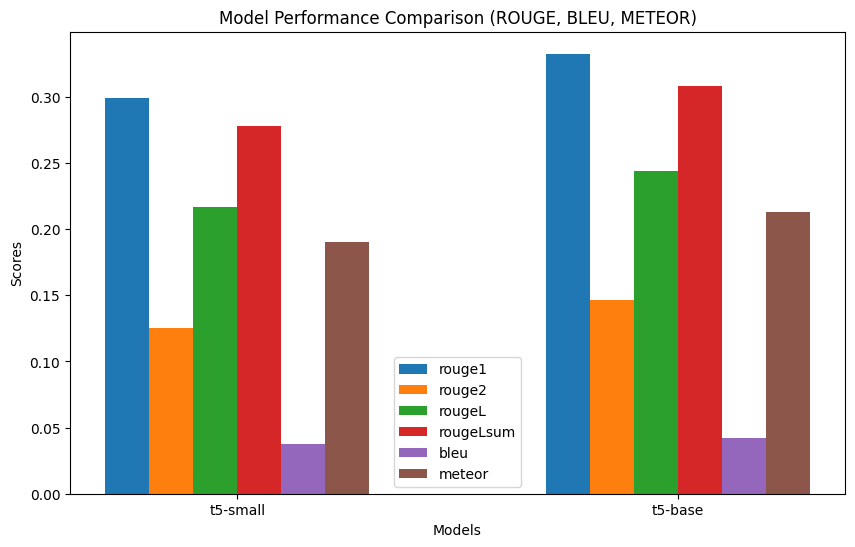

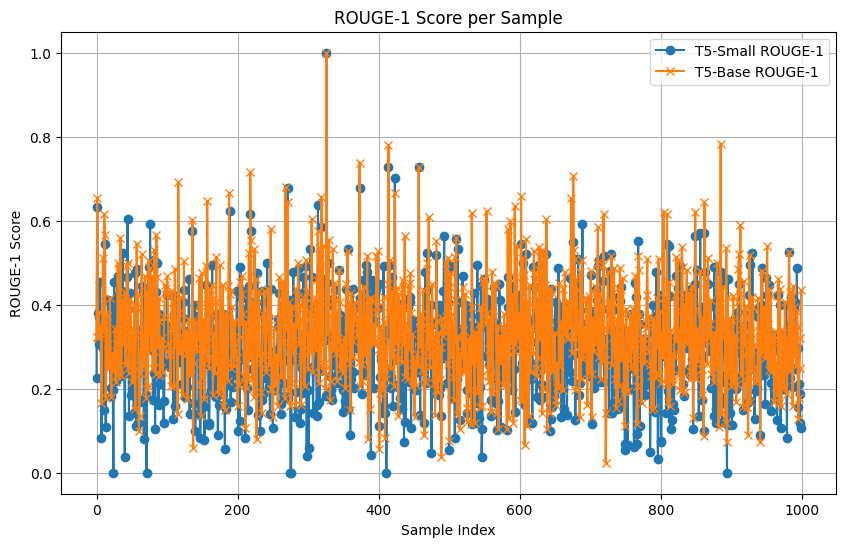

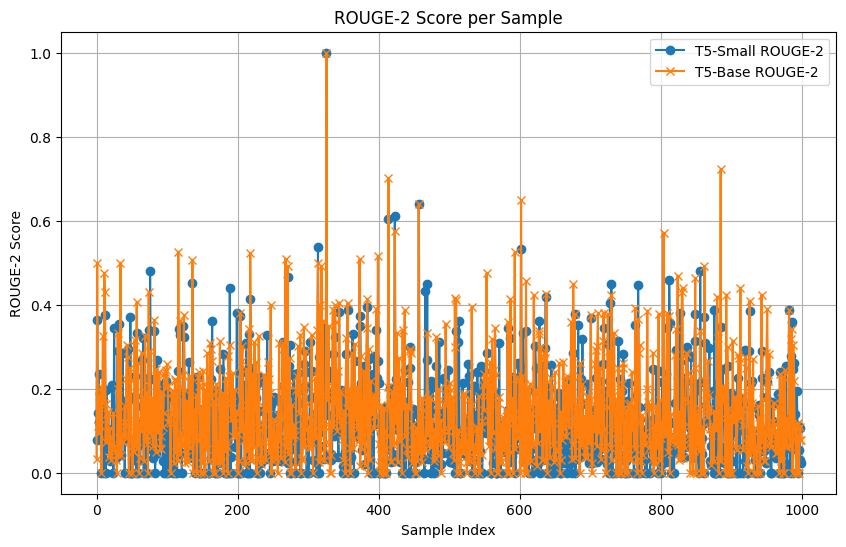

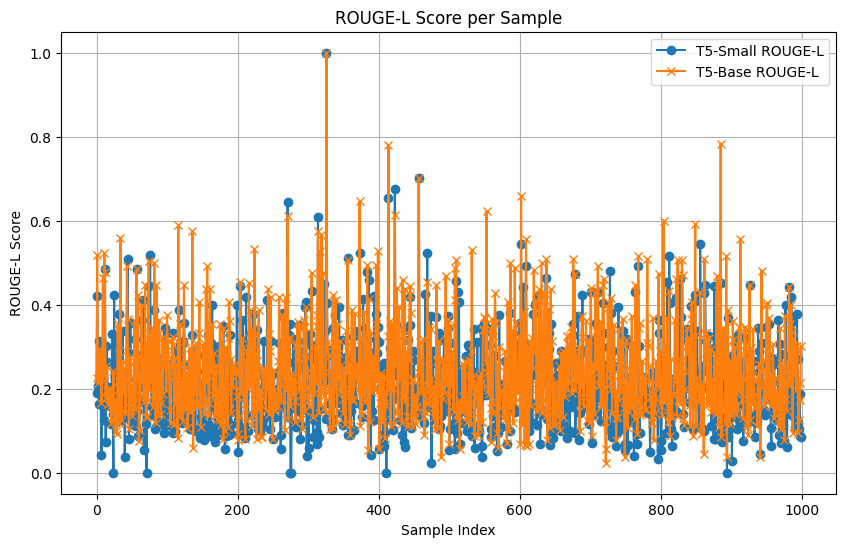

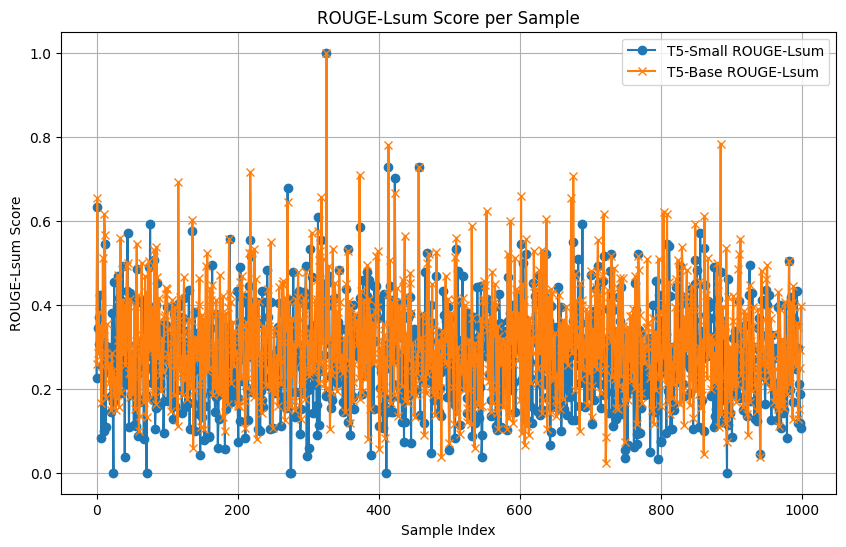

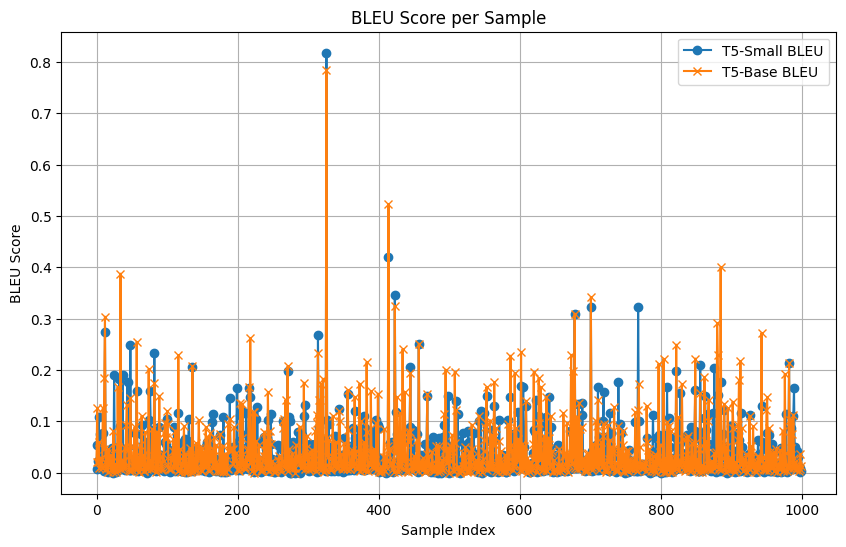

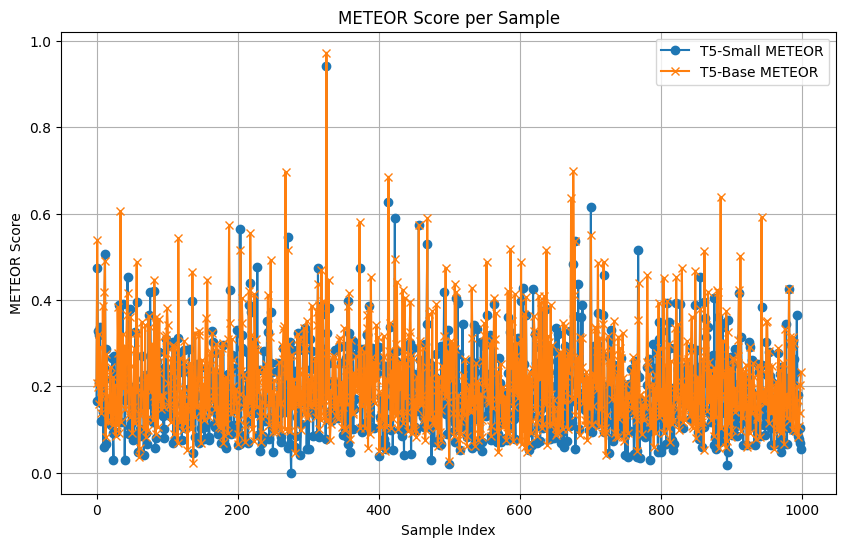

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Visualization of aggregate metrics (ROUGE, BLEU, METEOR)
def plot_aggregate_metrics(models_results):
    """
    Plots bar charts comparing the aggregate ROUGE, BLEU, and METEOR scores for different models.

    :param models_results: Dictionary of results per model
    """
    df = compare_models(models_results)

    metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum", "bleu", "meteor"]
    num_metrics = len(metrics)
    x = np.arange(len(df['model']))  # Model names for x-axis
    width = 0.1  # Width of bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot a bar for each metric
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, df[metric], width, label=metric)

    # Labeling
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Model Performance Comparison (ROUGE, BLEU, METEOR)')
    ax.set_xticks(x + width * (num_metrics - 1) / 2)
    ax.set_xticklabels(df['model'])
    ax.legend()

    plt.show()

# Call the plot function with your models' results
plot_aggregate_metrics({"t5-small": t5_small_results, "t5-base": t5_base_results})


# Visualization of metrics per sample
def plot_individual_metrics(t5_small_results, t5_base_results, sample_size):
    """
    Plots line charts for individual samples comparing ROUGE and BLEU scores between models.

    :param t5_small_results: Results from t5-small model
    :param t5_base_results: Results from t5-base model
    :param sample_size: Number of samples
    """
    indices = range(sample_size)

    # Plot for ROUGE-1
    plt.figure(figsize=(10, 6))
    plt.plot(indices, t5_small_results["rouge1"], label="T5-Small ROUGE-1", marker='o')
    plt.plot(indices, t5_base_results["rouge1"], label="T5-Base ROUGE-1", marker='x')
    plt.title("ROUGE-1 Score per Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("ROUGE-1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot for ROUGE-2
    plt.figure(figsize=(10, 6))
    plt.plot(indices, t5_small_results["rouge2"], label="T5-Small ROUGE-2", marker='o')
    plt.plot(indices, t5_base_results["rouge2"], label="T5-Base ROUGE-2", marker='x')
    plt.title("ROUGE-2 Score per Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("ROUGE-2 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot for ROUGE-L
    plt.figure(figsize=(10, 6))
    plt.plot(indices, t5_small_results["rougeL"], label="T5-Small ROUGE-L", marker='o')
    plt.plot(indices, t5_base_results["rougeL"], label="T5-Base ROUGE-L", marker='x')
    plt.title("ROUGE-L Score per Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("ROUGE-L Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot for ROUGE-Lsum
    plt.figure(figsize=(10, 6))
    plt.plot(indices, t5_small_results["rougeLsum"], label="T5-Small ROUGE-Lsum", marker='o')
    plt.plot(indices, t5_base_results["rougeLsum"], label="T5-Base ROUGE-Lsum", marker='x')
    plt.title("ROUGE-Lsum Score per Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("ROUGE-Lsum Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot for BLEU
    plt.figure(figsize=(10, 6))
    plt.plot(indices, t5_small_results["bleu"], label="T5-Small BLEU", marker='o')
    plt.plot(indices, t5_base_results["bleu"], label="T5-Base BLEU", marker='x')
    plt.title("BLEU Score per Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("BLEU Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot for METEOR
    plt.figure(figsize=(10, 6))
    plt.plot(indices, t5_small_results["meteor"], label="T5-Small METEOR", marker='o')
    plt.plot(indices, t5_base_results["meteor"], label="T5-Base METEOR", marker='x')
    plt.title("METEOR Score per Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("METEOR Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function for individual sample metrics
plot_individual_metrics(t5_small_results, t5_base_results, sample_size)

<ipython-input-27-d3ec26a1af6c>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_lengths = comparison_df.applymap(len)  # Get the length of each summary


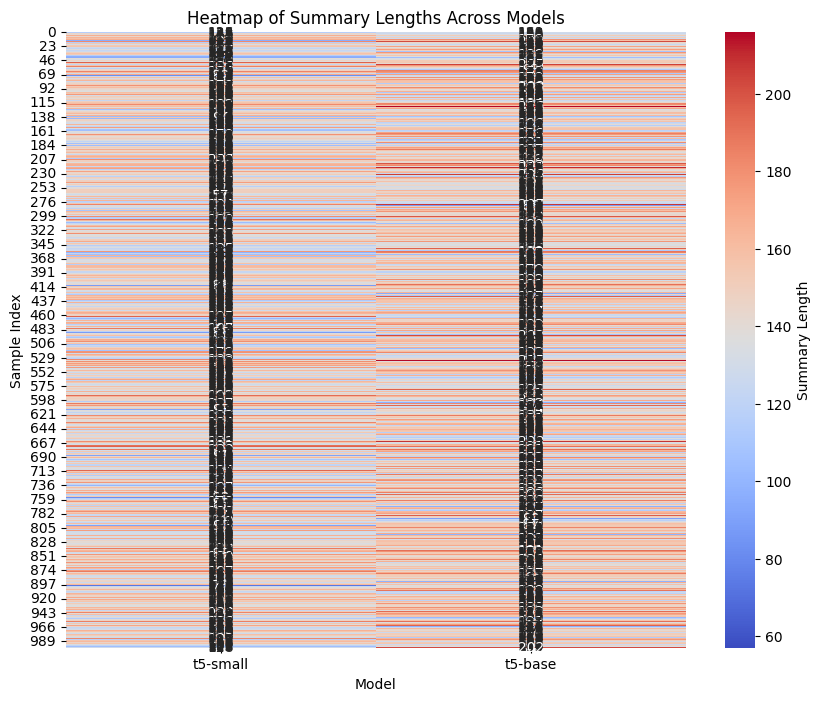

In [27]:

# Heatmap for comparing summaries
import seaborn as sns

def plot_summary_heatmap(models_summaries):
    """
    Plots a heatmap comparing the length of generated summaries across models.

    :param models_summaries: Dictionary of models and their generated summaries
    """
    comparison_df = compare_models_summaries(models_summaries)
    summary_lengths = comparison_df.applymap(len)  # Get the length of each summary

    plt.figure(figsize=(10, 8))
    sns.heatmap(summary_lengths, annot=True, fmt="d", cmap="coolwarm", cbar_kws={'label': 'Summary Length'})
    plt.title("Heatmap of Summary Lengths Across Models")
    plt.ylabel("Sample Index")
    plt.xlabel("Model")
    plt.show()

# Call the heatmap function
plot_summary_heatmap({"t5-small": t5_small_results, "t5-base": t5_base_results})
